In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import glob
import os
import os
import cv2
import glob
import numpy as np
import pandas as pd
import random
import pickle
from tqdm import tqdm
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix
from scipy import ndimage
import skimage
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit as s_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Conv2D , SeparableConv2D, BatchNormalization, UpSampling2D, MaxPool2D
from keras.layers import MaxPooling2D, Average, Input, Concatenate, LeakyReLU, Add, ELU, PReLU, ReLU
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras import backend as BE
from vis.visualization import visualize_cam, visualize_cam_with_losses, visualize_activation, visualize_saliency
from vis.utils import utils
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.utils import plot_model
from numpy.random import seed
from tensorflow import set_random_seed

c:\users\chandrachurh\appdata\local\programs\python\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
c:\users\chandrachurh\appdata\local\programs\python\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
c:\users\chandrachurh\appdata\local\programs\python\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


<font size=5>The data processing</font>

def set_data(path):
    for next_dir in os.listdir(path):
        temp = path + next_dir
        for dirc in os.listdir(temp):
            temp1 = path +next_dir+'/'+dirc
            for file in tqdm(os.listdir(temp1)):
                img = cv2.imread(temp1+"/"+file)
                img = cv2.resize(img, (50,50))
                if dirc =="0":
                    cv2.imwrite("data/NORMAL/"+file,img)
                else:
                    cv2.imwrite("data/IDC/"+file,img)

set_data("kaggle_data/")

<font size=5>The Model Development</font>

In [3]:
def get_image_data(path):
    X=[]
    y=[]
    for nextDir in os.listdir(path):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['IDC']:
                label = 1
            else:
                label = 2

            temp = path + nextDir

            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file, 1)
                img = cv2.resize(img,(100,100))
                img1 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))[0]
                img2 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))[0]
                img3 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))[1]
                img4 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))[1]
                if img is not None:
                    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(16,16))
                    planes = cv2.split(img)
                    for i in range(0,3):
                        planes[i] =clahe.apply(planes[i])
                    img = cv2.merge(planes)
                    #img = clahe.apply(img)
                    img = cv2.GaussianBlur(img,(5,5),0)
                    #img = skimage.transform.resize(img, (299, 299, 3))
                    img = cv2.merge([img,img1,img2,img3,img4])
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [4]:
X, y = get_image_data("fur_fur_fur_reduced_data/")

100%|█████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:11<00:00, 408.87it/s]


In [5]:
def shuffle_data(X_shu, y_shu):
    #X_shu=np.asarray(X_shu)
    #y_shu=np.asarray(y_shu)
    split = s_split(n_splits= 1, test_size = 0.15, random_state=18)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for train_id, test_id in split.split(X_shu, y_shu):
        X_train.append(X_shu[train_id])
        y_train.append(y_shu[train_id])
        X_test.append(X_shu[test_id])
        y_test.append(y_shu[test_id])
    #del X_shu
    #del y_shu
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = shuffle_data(X,y)
X_train = np.asarray(X_train, dtype = "float32")[0]
X_test = np.asarray(X_test, dtype = "float32")[0]
y_train = np.asarray(y_train)[0]
y_test = np.asarray(y_test)[0]

In [7]:
X_train /= 255
X_test /= 255

In [8]:
y_test = to_categorical(y_test,2)
y_train = to_categorical(y_train,2)

In [9]:
X_test.shape

(1125, 100, 100, 7)

<font size=5>The Model</font>

In [10]:
BE.clear_session()

In [11]:
def residual_block(mod_, f_in, f_out, strides_ = (1,1), use_shortcut_ = False):   
    shortcut_ = mod_
    
    k_ = (1,1)
    
    mod_ = Conv2D(f_in, kernel_size=k_, strides=(1,1), padding = "same")(mod_)
    mod_ = BatchNormalization()(mod_)
    mod_ = ELU()(mod_)
    
    mod_ = Conv2D(f_in, kernel_size=k_, strides=strides_, padding = "same")(mod_)
    mod_ = BatchNormalization()(mod_)
    mod_ = ELU()(mod_)
    
    mod_ = Conv2D(f_out, kernel_size=k_, strides=(1,1), padding = "same")(mod_)
    mod_ = BatchNormalization()(mod_)
    mod_ = ELU()(mod_)
    
    if use_shortcut_ == True or strides_ != (1,1):
        shortcut_ = Conv2D(f_out, kernel_size=k_, strides=strides_, padding = "same")(shortcut_)
        shortcut_ = BatchNormalization()(shortcut_)
        
    mod_ = Add()([shortcut_, mod_])
    mod_ = ReLU()(mod_)
    
    return mod_

In [12]:
def model_build(in_):
    
    k_=(1,1)
    
    mod_ = Conv2D(16, kernel_size=k_, strides = (1,1), padding = "same")(in_)
    
    mod_ = BatchNormalization()(mod_)
    
    mod_ = ReLU()(mod_)
    
    mod_ = MaxPooling2D()(mod_)
    
    mod_ = residual_block(mod_, 16, 32, use_shortcut_=True)
    
    mod_ = MaxPooling2D()(mod_)
    
    mod_ = residual_block(mod_, 32, 64, use_shortcut_=True)
    
    mod_ = MaxPooling2D()(mod_)
    
    mod_ = residual_block(mod_, 64, 96, use_shortcut_=True)
    
    mod_ = MaxPooling2D()(mod_)
    
    mod_ = residual_block(mod_, 96, 128, use_shortcut_=True)
    
    mod_ = MaxPooling2D()(mod_)
    
    mod_ = GlobalAveragePooling2D()(mod_)
    
    mod_ = Dense(512, activation = "relu")(mod_)
    
    mod_ = Dropout(0.5)(mod_)
    
    mod_ = Dense(2, activation="softmax")(mod_)
    
    return mod_

In [13]:
in_ = Input((100,100,7))
model = model_build(in_)

In [14]:
model_f = Model(input = in_, output = model)

c:\users\chandrachurh\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [15]:
model_f.compile(optimizer = RMSprop(), loss = "binary_crossentropy", metrics=["accuracy"])
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 7)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 16) 128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 100, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 100, 100, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 12, 12, 96)   6240        elu_8[0][0]                      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 12, 12, 96)   6240        max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 12, 12, 96)   384         conv2d_12[0][0]                  
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 12, 12, 96)   384         conv2d_13[0][0]                  
__________________________________________________________________________________________________
elu_9 (ELU)                     (None, 12, 12, 96)   0           batch_normalization_12[0][0]     
__________

<font size=5>Specifying parameters</font>

In [ ]:
nb_epochs = 50
nb_batch = 20

earlyStopping=EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

save_path="weights/res5_7x7_BGR_l_h_s_a_clahe_20_blur_new_fur_fur_fur_reddata_ELU_acti_convo_test_lastelu.h5"

checkpoint = ModelCheckpoint(save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history=model_f.fit(X_train, y_train, epochs = nb_epochs, batch_size = nb_batch, callbacks=[earlyStopping, lr_reduce, checkpoint], validation_data=(X_test, y_test), verbose = 2)

In [ ]:
with open('history/res4_1x1_BGR_l_h_s_a_clahe_20_blur_new_fur_fur_fur_reddata_ELU_acti_convo_test_lastelu', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [16]:
model_f.load_weights("weights/res4_1x1_BGR_l_h_s_a_clahe_20_blur_new_fur_fur_fur_reddata_ELU_acti_convo_test_lastelu.h5")

In [17]:
model_f.evaluate(X_test,y_test,verbose=2)

[0.022613801583406208, 0.9937777777777778]

<font  size=5>Visualization</font>

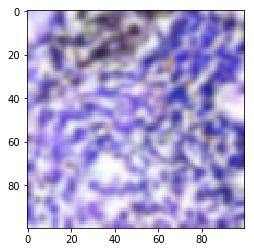

In [18]:
idx=13
plt.imshow(cv2.merge(cv2.split(X_test[idx])[0:3]))

In [19]:
x = np.expand_dims(X_test[idx], axis=0)

In [20]:
model_f.predict(x, verbose=1)[0].argmax(axis=0)

1/1 [==============================] - 0s 266ms/step


0

In [21]:
y_test[idx]

array([1., 0.], dtype=float32)

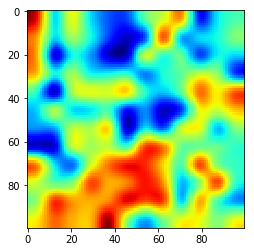

In [22]:
plt.imshow(visualize_cam(model=model_f, layer_idx=utils.find_layer_idx(model_f, 're_lu_4'), filter_indices=None, seed_input=np.asarray(X_test[idx]), penultimate_layer_idx=utils.find_layer_idx(model_f, 'add_3'), \
    backprop_modifier=None, grad_modifier=None))

<font size =  5>The performance metrics</font>

In [23]:
y_test_labels = np.argmax(y_test, axis = 1)
y_test_pred_incep = np.argmax(model_f.predict(X_test),axis = 1)
print(precision_score(y_test_labels, y_test_pred_incep))
print(recall_score(y_test_labels, y_test_pred_incep))

0.9889624724061811
0.9955555555555555


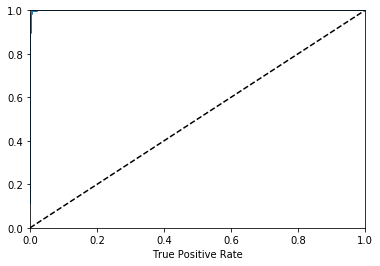

0.9996411522633745

In [24]:
y_pred_probs = model_f.predict([X_test])
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_probs[:, 1])
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.xlabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()
roc_auc_score(y_test_labels,y_pred_probs[:,1])

In [25]:
filename = open('history/res3_3x3_BGR_l_h_s_a_clahe_24_blur_new_fur_fur_reddata_acti',"rb")
history = pickle.load(filename)
print(history.keys())

dict_keys(['loss', 'lr', 'val_loss', 'acc', 'val_acc'])


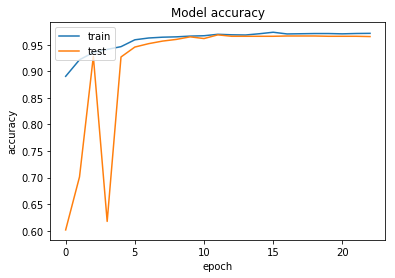

In [26]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

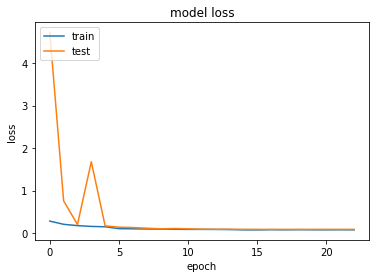

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()